In [1]:
%conda install pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import UndefinedMetricWarning

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, message="A single label was found in 'y_true' and 'y_pred'.")
warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

Channels:
 - defaults
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/matt/projects/project4-knn-cs5830/.conda

  added / updated specs:
    - matplotlib
    - numpy
    - pandas
    - scikit-learn


The following NEW packages will be INSTALLED:

  alsa-lib           conda-forge/linux-64::alsa-lib-1.2.12-h4ab18f5_0 
  attr               conda-forge/linux-64::attr-2.5.1-h166bdaf_1 
  blas               pkgs/main/linux-64::blas-1.0-openblas 
  bottleneck         pkgs/main/linux-64::bottleneck-1.3.7-py311hf4808d0_0 
  brotli             pkgs/main/linux-64::brotli-1.0.9-h5eee18b_8 
  brotli-bin         pkgs/main/linux-64::brotli-bin-1.0.9-h5eee18b_8 
  cairo              conda-forge/linux-64::cairo-1.18.0-hebfffa5_3 
  contourpy          pkgs/main/linux-64::contourpy-1.2.0-py311hdb19cb5_0 
  cycler             pkgs/main/noarch::cycler-0.11.0-pyhd3eb1b0_0 
  dbus               pkgs/main/linux-64::dbus-1.13.18-hb2f20db_0 
  expat

In [2]:
# Sourced from CDC BRFSS 2015 https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?resource=download
diabetes = pd.read_csv('data/archive/diabetes_binary_health_indicators_BRFSS2015.csv')
diabetes.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
def load_and_preprocess_data(file_path, target_column, test_size=0.2, random_state=42):
    data = pd.read_csv(file_path)
    X = data.drop(target_column, axis=1)
    y = data[target_column]
    
    # Convert target to binary classification if not already
    if y.nunique() > 2:
        y = y.apply(lambda x: 1 if x > y.median() else 0)
    
    X = X.replace('?', np.nan).astype(float)
    X = X.fillna(X.mean())
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)
    
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        return X_train, X_test, y_train, y_test
    else:
        return X, y

In [4]:
def select_features(X, y, k, method='univariate'):
    if method == 'univariate':
        selector = SelectKBest(f_classif, k=k)
    elif method == 'mutual_info':
        selector = SelectKBest(mutual_info_classif, k=k)
    elif method == 'rfe':
        selector = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=k)
    elif method == 'random_forest':
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X, y)
        importances = rf.feature_importances_
        indices = np.argsort(importances)[::-1]
        return X.columns[indices[:k]].tolist()
    else:
        raise ValueError("Invalid method. Choose 'univariate', 'mutual_info', 'rfe', or 'random_forest'.")
    
    selector.fit(X, y)
    return X.columns[selector.get_support()].tolist()

In [5]:
def get_model():
    return LogisticRegression(max_iter=1000)

def safe_balanced_accuracy(y_true, y_pred):
    try:
        return balanced_accuracy_score(y_true, y_pred)
    except ValueError:
        return float(y_true.iloc[0] == y_pred[0])

def evaluate_model_loocv(X, y):
    loo = LeaveOneOut()
    model = get_model()
    scores = []
    n_samples = X.shape[0]
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        score = safe_balanced_accuracy(y_test, y_pred)
        scores.append(score)
        
        if (len(scores) % 50 == 0) or (len(scores) == n_samples):
            print(f"Processed {len(scores)}/{n_samples} samples. Current average score: {np.mean(scores):.3f}")
    
    return np.mean(scores)

In [6]:
def evaluate_model_with_feature_selection(X, y, k, method='univariate', n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        selected_features = select_features(X_train, y_train, k, method)
        X_train_selected = X_train[selected_features]
        X_test_selected = X_test[selected_features]
        
        model = get_model()
        model.fit(X_train_selected, y_train)
        
        y_pred = model.predict(X_test_selected)
        
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
    
    return precision_scores, recall_scores, f1_scores, selected_features


In [7]:
def compare_feature_selection_methods(X, y, methods, k_range):
    results = {}
    for method in methods:
        method_results = []
        for k in k_range:
            _, _, f1_scores, _ = evaluate_model_with_feature_selection(X, y, k, method)
            method_results.append(np.mean(f1_scores))
        results[method] = method_results
    return results

Processed 50/303 samples. Current average score: 0.880
Processed 100/303 samples. Current average score: 0.840
Processed 150/303 samples. Current average score: 0.853
Processed 200/303 samples. Current average score: 0.840
Processed 250/303 samples. Current average score: 0.844
Processed 300/303 samples. Current average score: 0.833
Processed 303/303 samples. Current average score: 0.832
Ideal (Leave-One-Out): 0.832


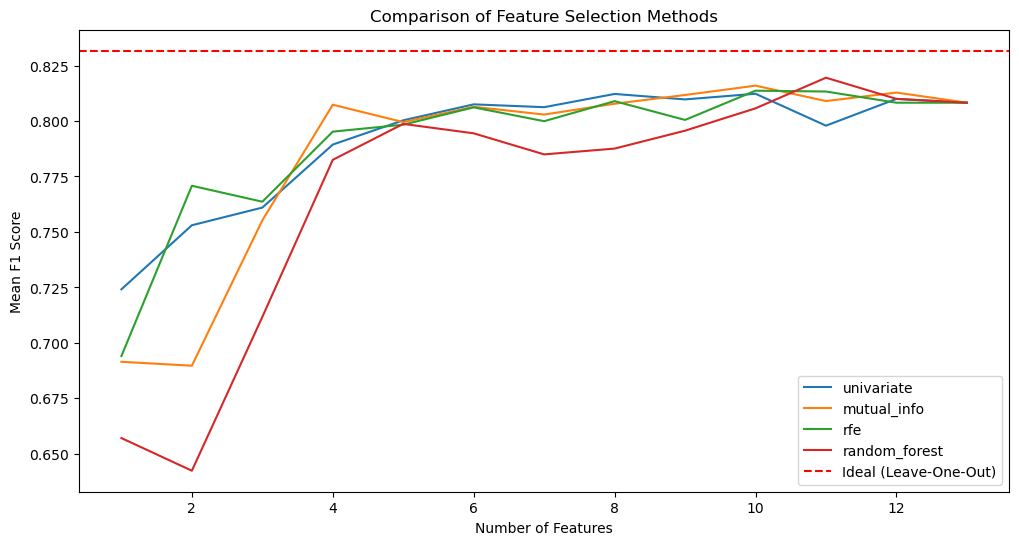

Best method: random_forest
Best number of features: 11

Final Results:
Mean Precision: 0.841
Mean Recall: 0.814
Mean F1 score: 0.820
Best features: ['thalach', 'cp', 'thal', 'ca', 'oldpeak', 'age', 'chol', 'trestbps', 'slope', 'exang', 'sex']

Test Set Results:
Precision: 0.938
Recall: 0.833
F1 Score: 0.882


In [8]:
def train_and_evaluate_model(train_file, test_file=None, target_column='target', test_size=0.2):
    if test_file:
        X_train, y_train = load_and_preprocess_data(train_file, target_column, test_size=0)
        X_test, y_test = load_and_preprocess_data(test_file, target_column, test_size=0)
    else:
        X_train, X_test, y_train, y_test = load_and_preprocess_data(train_file, target_column, test_size=test_size)
    
    # Calculate the ideal test condition using Leave-One-Out
    ideal = evaluate_model_loocv(X_train, y_train)
    print('Ideal (Leave-One-Out): %.3f' % ideal)
    
    # Compare different feature selection methods
    methods = ['univariate', 'mutual_info', 'rfe', 'random_forest']
    k_range = range(1, len(X_train.columns) + 1)
    results = compare_feature_selection_methods(X_train, y_train, methods, k_range)
    
    # Plot comparison of feature selection methods
    plt.figure(figsize=(12, 6))
    for method in methods:
        plt.plot(k_range, results[method], label=method)
    plt.axhline(y=ideal, color='r', linestyle='--', label='Ideal (Leave-One-Out)')
    plt.xlabel('Number of Features')
    plt.ylabel('Mean F1 Score')
    plt.title('Comparison of Feature Selection Methods')
    plt.legend()
    plt.show()
    
    # Find best method and k
    best_method = max(results, key=lambda x: max(results[x]))
    best_k = k_range[np.argmax(results[best_method])]
    print(f"Best method: {best_method}")
    print(f"Best number of features: {best_k}")
    
    # Evaluate with best method and k
    precision_scores, recall_scores, f1_scores, best_features = evaluate_model_with_feature_selection(X_train, y_train, best_k, best_method)
    
    print("\nFinal Results:")
    print(f"Mean Precision: {np.mean(precision_scores):.3f}")
    print(f"Mean Recall: {np.mean(recall_scores):.3f}")
    print(f"Mean F1 score: {np.mean(f1_scores):.3f}")
    print(f"Best features: {best_features}")
    
    # Train final model and evaluate on test set
    X_train_selected = X_train[best_features]
    X_test_selected = X_test[best_features]
    
    final_model = get_model()
    final_model.fit(X_train_selected, y_train)
    
    y_pred = final_model.predict(X_test_selected)
    
    print("\nTest Set Results:")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Recall: {recall_score(y_test, y_pred):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
    
    return final_model, best_features

if __name__ == "__main__":
    # train_file = 'data/archive/diabetes_binary_health_indicators_BRFSS2015.csv'
    # test_file = None
    train_file = 'data/cleveland.csv'
    test_file = 'data/cleveland-test-sample.csv'
    # target_column = 'Diabetes_binary'
    target_column = 'num'
    
    trained_model, selected_features = train_and_evaluate_model(train_file, test_file, target_column)